### Hozefa Lakdawala
### Amit Luhar
### Abha Chaudhary

The usual, Imports

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary

Displaying the graph

In [2]:
def plot_the_graph(train_losses,val_losses,val_accuracies,num_epochs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Loading and PreProcessing the Data

In [3]:
train_path = "FER-13/train"
test_path = "FER-13/test"


In [4]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

In [6]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


In [7]:
batch_size = 256
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


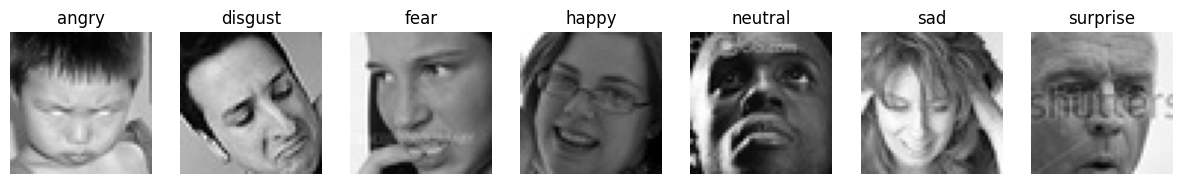

In [8]:
classes = os.listdir(train_path)
fig, axs = plt.subplots(1, 7, figsize=(15, 5))
for i, class_name in enumerate(classes):
    img_path = os.path.join(train_path, class_name, os.listdir(os.path.join(train_path, class_name))[0])
    img = Image.open(img_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(class_name)
    axs[i].axis('off')
plt.show()

Creating the Model

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7,dropout=False):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        if dropout:
            self.dropout = torch.nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

To use dropout and other regularization techniques, set the paramaters in the model

In [10]:
model = SimpleCNN(dropout=False).to(device)
print(model)
# summary(model,(1,256 * 3 * 3, 1024))

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
)


Training Simple CNN model

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    return train_losses,val_losses,val_accuracies

In [13]:
n_epochs = 10
train_losses,val_losses,val_accuracies = train_model(model, train_loader, val_loader, criterion,optimizer, num_epochs=n_epochs, learning_rate=0.001)

Displaying the Graph

In [ ]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,val_accuracies=val_accuracies,num_epochs=n_epochs)

Evaluating the simple cnn model on Test dataset

In [ ]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
test_model(model, test_loader)

Saving the Model

In [ ]:
model_path = "simple_cnn_model.pth"
torch.save(model.state_dict(),model_path)

Training the Model with droupouts

In [ ]:
model = SimpleCNN(dropout=True).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
n_epochs = 10
train_losses,val_losses,val_accuracies = train_model(model, train_loader, val_loader, criterion,optimizer, num_epochs=10, learning_rate=0.001)

Displaying the Graph

In [ ]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,val_accuracies=val_accuracies,num_epochs=n_epochs)

Evaluating the Model

test_model(model, test_loader)

Saving the Model with dropouts

In [ ]:
model_path = "cnn_model.pth"
torch.save(model.state_dict(),model_path)

Training the Model with droupouts and regularization

In [ ]:
model = SimpleCNN(dropout=True).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
n_epochs = 10
train_losses,val_losses,val_accuracies = train_model(model, train_loader, val_loader, criterion,optimizer, num_epochs=10, learning_rate=0.001)

Displaying the Graph

In [ ]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,val_accuracies=val_accuracies,num_epochs=n_epochs)

Evaluating the Model

test_model(model, test_loader)

Saving the Model with dropouts

In [ ]:
#model_path = "cnn_model.pth"
#torch.save(model.state_dict(),model_path)
print("Hi")